***COMP 691 - Deep Learning project - Challenge 1***

*Team: DL_DT_Explore*

*Members*:
* Trong-Tuan Tran
* Hussein Abdallah
* Manh-Quoc-Dat Le

Jupyter Notebook implement the approach: ResNet9 model for feature embedding using triplet loss and SVM classifier.

Here the goal is to train on 100 samples. In this preliminary testbed the evaluation will be done on a 2000 sample validation set. Note in the end the final evaluation will be done on the full CIFAR-10 test set as well as potentially a separate dataset. The validation samples here should not be used for training in any way, the final evaluation will provide only random samples of 100 from a datasource that is not the CIFAR-10 training data. 

Initial configurations:

*(Please note that due to the need to support resume random search capability, some hyperparameters will need to be defined later, after the environment detecting section)*

In [8]:
import time
import pickle
from scipy.stats import loguniform
from numpy.random import RandomState
import torchvision
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

search_plot = True
log_enabled = False
save_image = True
summarize = False
plot_distance = True
google_drive_mount = True # If running in Google Colab and enable this, progress and image files will save to Google Drive instead of local file
final_eval = True # Whether to run using train set or test set for final evalutation & submission
linear_classifier = 'SVM' #'KNN' # Decide which linear classifier to use on top of the ResNet9 layers, on the embed features
batch_multiplier = 10 # Number of augmented minibatches to be accumulated into a big batch to generate online triplets
hard_neg_prob = torch.tensor(0.1) # Probability of a accumulated batch to be mined with hard negative or semi-hard negative triplet selection 

batch_size = 500
runs = 3 # Number of instances to run the train and test to evaluate mean and std dev of test accuracy

epoch_display_range = 20

eval_str = 'DEV PHASE - ' if not final_eval else 'FINAL EVAL - '

# Comments to put on accuracy curve plot:
comment = eval_str + f'ResNet9 + Data Augmentation + no lr sched + Triplet loss ({(hard_neg_prob*100):.1f}% hard negative) + SVM'
if final_eval:
    search_plot = False
    save_image = False
    google_drive_mount = False
    log_enabled = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device('cpu')

The section below detects which environment is running (Colab, Kaggle or local computer). The output folders will be determine accordingly. If running in final_eval mode, no output file will be generated.

In [9]:
import os
output_path = 'output_txt/'
img_path = 'img/'
Colab = False
Kaggle = 'kaggle' in os.getcwd()
root = '.' # Root to download dataset
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    Colab = True  
    from google.colab import drive
    if not os.path.exists('/content/drive/MyDrive/') and google_drive_mount:
        drive.mount('/content/drive', force_remount=False)

    else:
        if google_drive_mount:
            print('Drive already mounted at at /content/drive')

    Google_path = '/content/drive/MyDrive/Colab Notebooks/COMP691_project/' if google_drive_mount else '/'
    if not os.path.exists(Google_path):
        os.mkdir(Google_path)
    img_path = Google_path + img_path
    if not os.path.exists(img_path):
        os.mkdir(img_path)
    output_path = Google_path + output_path  
else:
    if Kaggle:
        root = '../input/cifar10'
        output_path = '/'
        img_path = 'img/'
        print('Running in Kaggle')
    else:
        print('Not running on CoLab or Kaggle')

output_file_name = 'report_ADAM_Triplet_SVM_ResNet9_GridSearch_FINAL.txt'
output_file_path = output_path + output_file_name
progress_file = output_path + 'Triplet_SVM_grid_search_ResNet9_progress_FINAL.txt'
img_file_name_prefix = output_file_name.replace('.txt', '')
img_file_path = img_path + img_file_name_prefix + '/'
save_state_file_path = output_file_path.replace('.txt', '.pkl')

if not final_eval:
    if not os.path.exists(img_path):
        os.mkdir(img_path)

    if not os.path.exists(img_file_path):
        os.mkdir(img_file_path)

    if not os.path.exists(output_path):
        os.mkdir(output_path)

Running on CoLab


This section define hyperparameters and check if there is an pending run not completed before. If yes, it will resume using the stored settings regardless of the entered hyperparameters below.

In [10]:
save_state = {}
if summarize:
    if not log_enabled:
        raise NameError('log_enabled should be True in order to enable summarize!')
    if os.path.exists(save_state_file_path):
        with open(save_state_file_path ,'rb') as dataHandle:
            save_state = pickle.load(dataHandle)

accumulated_accs = []
# Epochs: 300 - lr: - 0.001 - dropout: 0 - Weight_decay: 1e-05 - Grad_clip: 0.005 
# Epochs: 700 - lr: - 0.0001 - dropout: 0 - Weight_decay: 0.00016052 - Grad_clip: 0.01512
if len(save_state) == 0:
    epochs_list = [400]
    save_state['epochs'] =  epochs_list

    # grad_clips = sorted(list(loguniform(1e-4, 1).rvs(5, random_state=0)))
    grad_clips = [0.005] # Gradient clipping

    save_state['grad_clips'] = grad_clips
    # weight_decays = sorted(list(loguniform(1e-5, 1e-3).rvs(5, random_state=0)))
    weight_decays = [1e-5] # Weight decay for Adam optimizer

    save_state['weight_decays'] = weight_decays
    
    lrs = [0.005] # learning rates
    save_state['lrs'] = lrs
    
    alphas = [0.3] # margin in triplet loss
    save_state['alphas'] = alphas

    ks = [9] # k in k-Nearest Neighbor classifier
    save_state['ks'] = ks
    #drop_outs = [0, 0.1, 0.2]
    drop_outs = [0]
    save_state['drop_outs'] = drop_outs
    if summarize:
        with open(save_state_file_path, 'wb') as dataHandle:
            pickle.dump(save_state, dataHandle)
    
    print(f'First time run on profile {output_file_name}') 
else:
    epochs_list = save_state['epochs']
    grad_clips = save_state['grad_clips']
    weight_decays = save_state['weight_decays']
    lrs = save_state['lrs']
    alphas = save_state['alphas']
    ks = save_state['ks']
    drop_outs = save_state['drop_outs']
    accumulated_accs = save_state['accs']
    print(f'Successfully loaded save state from profile {output_file_name}') 



First time run on profile report_ADAM_Triplet_SVM_ResNet9_GridSearch_FINAL.txt


Setup training, testing and other helper functions.

In [11]:
import gc
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
import numpy as np
from numpy import unravel_index
import torch

def train(model, device, train_loader, optimizer, epoch, alpha=0.2, grad_clip=None, 
          sched=None, display=True, distance_visualize=True, scenario_description='', svm=False):
    
    loss_function = nn.TripletMarginLoss(margin=alpha)
    model = model.to(device)
    acc_data = torch.tensor([])
    acc_target = torch.tensor([])
    for i in range(batch_multiplier):
        for data, target in train_loader:
            acc_data = torch.cat([acc_data, data])
            acc_target = torch.cat([acc_target, target])

    
    #print(acc_data.size(0))
    hard_negative = bool(torch.bernoulli(hard_neg_prob).item())
    if not hard_negative:
    #data, target = data.to(device), target.to(device)
        (data_a, data_p, data_n), _ = triplet_generate_random((acc_data, acc_target), timing=False)
    else:
        (data_a, data_p, data_n), _ = triplet_generate_hard_negative_mining((acc_data, acc_target), model, alpha, device, timing=False)
    l = 0
    for i in range(0, data_a.size(0), batch_size):
        data_a_batch = data_a[i:i+batch_size].to(device)
        data_p_batch = data_p[i:i+batch_size].to(device)
        data_n_batch = data_n[i:i+batch_size].to(device)

        optimizer.zero_grad()
        #data_a, data_p, data_n = data_a.to(device), data_p.to(device), data_n.to(device)
        model.train()
        embedded_a = model(data_a_batch)
        embedded_p = model(data_p_batch)
        embedded_n = model(data_n_batch)
    
        loss = loss_function(embedded_a, embedded_p, embedded_n)
        #loss = F.cross_entropy(output, target)
        loss.backward()
        l += loss.detach().item()
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        if sched:
            sched.step()
        del loss, embedded_a, embedded_p, embedded_n, data_a_batch, data_p_batch, data_n_batch
        gc.collect()
        if device == torch.device('cuda'):
            torch.cuda.empty_cache()

    if svm:
        with torch.no_grad():
            embeded_data = model(acc_data.to(device))
        print('  Start fitting svm model with random search cv...')
        model.fit(embeded_data, acc_target)
    if display:
        print('   Train Epoch: {}\tAvg Loss: {:.6f}'.format(
            epoch + 1, l/int(data_a.size(0)/batch_size)))
    embeded_data = None
    if distance_visualize or not svm:
        model.eval() # switch to eval mode to store a copy of current embed data to be used for k-NN predict in test phase
        with torch.no_grad():
            embeded_data = model(acc_data.to(device))
            embed_dict = {'embed_data': (embeded_data, acc_target)}
            embed_data_file = 'embed_data.pkl'
            with open(embed_data_file, 'wb') as dataHandle:
                pickle.dump(embed_dict, dataHandle) 
            #model.embeded_data = 
        if distance_visualize:
            comment = f'Epoch: {epoch + 1} - Batch multiplier: x{batch_multiplier} - hard negative prob: {hard_neg_prob.item():.2f}'
            visualize_distances((embeded_data, acc_target), display_str=scenario_description, comment=comment, save_img=save_image)
    
    del acc_data, acc_target, embeded_data, embed_dict
    gc.collect()
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()

def test(model, device, test_loader, k, display=True, distance_visualize=True, svm=False):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    correct_knn = 0
    #loss_function = nn.CrossEntropyLoss()
    classifier = 'k-NN'
    benchmark_str = '' 
    data_embedded = None
    if distance_visualize or not svm:
        embed_data_file = 'embed_data.pkl'
        if os.path.exists(embed_data_file):
            with open(embed_data_file ,'rb') as dataHandle:
                embed_data_dict = pickle.load(dataHandle)
        train_embeded_data, labels = embed_data_dict['embed_data']
        train_embeded_data, labels = train_embeded_data.to(device), labels.to(device)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data_embedded = None
            if not svm:
                data_embedded = model(data)
                output = k_nearest_neighbors(data_embedded, (train_embeded_data, labels), k).to(device)
                #print(output.shape, target.shape)        
                #test_loss += loss_function(output, target).item() # sum up batch loss
                #test_loss += F.cross_entropy(output, target, size_average=False).item()
                #pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                
            else:
                classifier = 'SVM'
                output = model(data, svm_predict=svm).to(device)
                if distance_visualize:
                    data_embedded = model(data)
                    output_knn = k_nearest_neighbors(data_embedded, (train_embeded_data, labels), k).to(device)
                
            correct += output.eq(target.view_as(output)).sum().item()
            if svm & distance_visualize:
                correct_knn += output_knn.eq(target.view_as(output)).sum().item()
                benchmark_str = f' - k-NN acc benchmark: {correct_knn}/{len(test_loader.dataset)} ({100. * correct_knn / len(test_loader.dataset):.2f}%)'
            del output, data, target, data_embedded
            gc.collect()
            if device == torch.device('cuda'):
                torch.cuda.empty_cache()
    test_loss /= len(test_loader.dataset)
    if display:
        print('   Test set: Accuracy: {}/{} ({:.2f}%) - classifier: {}'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset), classifier) + benchmark_str)
        
    del train_embeded_data, labels, embed_data_dict 
    gc.collect()
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()
    return 100. * correct / len(test_loader.dataset)


def triplet_generate_random(minibatch, timing=False):
    start_time = time.time()
    image, labels = minibatch
    label_set = labels.unique().tolist()
    label_to_indices = {label: np.where(labels.numpy() == label)[0] for label in label_set} 
    #print(label_to_indices)
    idx_pos = []
    idx_neg = []

    for idx, label in enumerate(labels):
        positive_index = idx
        #print(positive_index, idx)
        while positive_index == idx:
            positive_index = np.random.choice(label_to_indices[label.item()])
            #print(positive_index)
        negative_labels = np.random.choice(list(set(label_set) - set([label.item()])))
        negative_index = np.random.choice(label_to_indices[negative_labels])
        idx_pos.append(positive_index)
        idx_neg.append(negative_index)
    if timing:
        execution_time = time.time() - start_time
        print(f'Found [{len(idx_pos)}/{labels.size(0)}] random triplets - Duration: {execution_time:.3f}s')
    return (image, image[idx_pos], image[idx_neg]), (labels, labels[idx_pos], labels[idx_neg])


def triplet_generate_hard_negative_mining(minibatch, model, margin, device, timing=False):
    start_time = time.time()
    image, labels = minibatch
    image, labels = image.to(device), labels.cpu()
    model = model .to(device)
    model.train()
    semi_hard_prob = torch.tensor(0.4)
    
    semi_hard_count = 0
    label_set = labels.unique().tolist()
    label_to_indices = {label: np.where(labels.numpy() == label)[0] for label in label_set}


    idx_anchor = []
    idx_pos = []
    idx_neg = []

    with torch.no_grad():
        embed_data = model(image)
    #print(embed_data.max(), embed_data.min(), embed_data.mean() ,embed_data.std())
    distances = torch.cdist(embed_data, embed_data)
    sorted_distances, sort_indices = distances.topk(k=distances.size(1), largest=False)
    missed_hard_neg_count = 0
    missed_semi_hard_neg_count = 0
    for i, label in enumerate(labels):
        #print(f'label_idx: {i} - class: {label.item()}')
        triplet_selected = False
        current_sort_distances = sorted_distances[i]
        current_sort_indices = sort_indices[i]
        semi_hard = bool(torch.bernoulli(semi_hard_prob).item())
        pos_index, neg_index, sh_count, semi_hard = triplet_pair_select_hard_negative(i, current_sort_distances, current_sort_indices, 
                                                                           labels, margin, semi_hard)
        
        if pos_index != -1 and neg_index != -1:
            idx_anchor.append(i)
            idx_pos.append(pos_index)
            idx_neg.append(neg_index)
            if semi_hard:
                semi_hard_count += sh_count
        else: 
            if semi_hard:
                missed_semi_hard_neg_count += 1
            else:
                missed_hard_neg_count += 1
    del embed_data
    gc.collect()
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()
    if timing:
        execution_time = time.time() - start_time
        print(f'   Found [{len(idx_anchor)}/{labels.size(0)}] pairs of hard-negative triplets in current minibatch, semi-hard pairs: {semi_hard_count} ' + \
              f'- Missed hard pair(s): {missed_hard_neg_count} - Missed semi-hard pair(s): {missed_semi_hard_neg_count} - Duration: {execution_time:.3f}s')
    return (image[idx_anchor], image[idx_pos], image[idx_neg]), (labels[idx_anchor], labels[idx_pos], labels[idx_neg])

def triplet_pair_select_hard_negative(idx_anchor, current_sort_distances, current_sort_indices, labels, margin, semi_hard=False):
    idx_pos = -1
    idx_neg = -1
    label_a = labels[idx_anchor].item()
    triplet_pair_found = False
    semi_hard_count = 0
    #print('semi-hard:', semi_hard)
    
    for j, candidate_distance_n in enumerate(current_sort_distances): # Start from the left (smallest distances)
    
        if j == idx_anchor:
            continue # skip if current column is the anchor itself
        
        distance_idx_j = current_sort_indices[j].item()
        candidate_label_n = labels[distance_idx_j].item()
        #print(f'j: {j} - candidate_distance_n: {candidate_distance_n}, candidate_label_n: {candidate_label_n}')
        if candidate_label_n == label_a:
            continue
        k = len(current_sort_distances) - 1
        while not triplet_pair_found and k >= 0:
            if k == idx_anchor:
                k -= 1
                continue
            candidate_distance_p = current_sort_distances[k]
            distance_idx_k = current_sort_indices[k].item()
            candidate_label_p = labels[distance_idx_k].item()
            
            if candidate_label_p == label_a:
                if not semi_hard:
                    if candidate_distance_n.item() < candidate_distance_p.item():
                        triplet_pair_found = True
                        idx_pos = distance_idx_k
                        idx_neg = distance_idx_j
                        #print(f'  k: {k} - candidate_distance_p: {candidate_distance_p}, candidate_label_p: {candidate_label_p}')
                        break
                    #else:
                        #if k == j & j == :
                            #semi_hard = True # if cannot find hard negative pair, switch to to continue searching for a semi-hard pair instead
  
                else: # semi-hard mining
                    if k >= j:
                        k -= 1
                        continue
                    if candidate_distance_n.item() > candidate_distance_p.item() and \
                        candidate_distance_n.item() < candidate_distance_p.item() + margin:
                        triplet_pair_found = True
                        idx_pos = distance_idx_k
                        idx_neg = distance_idx_j
                        semi_hard_count = 1
                        #print(f'  k: {k} - candidate_distance_p: {candidate_distance_p}, candidate_label_p: {candidate_label_p}')
                        break
                    if k < j and candidate_distance_n.item() > candidate_distance_p.item() + margin:
                        break # early break moving positive to the left (while loop) if negative already goes exceeded positive + margin
 
                        #semi_hard = False
                        #k = len(current_sort_distances) - 1
                        #continue # if canno find semi-hard pair, reset k and switch to find searching for hard neg mining
            k -= 1
        
        if triplet_pair_found:
            break
    
    return idx_pos, idx_neg, semi_hard_count, semi_hard 

def k_nearest_neighbors(minibatch_embbed, trained_embeded_set, k=1):
    minibatch_embbed = minibatch_embbed
    train_embeded_data, train_labels = trained_embeded_set
    predicts = np.zeros(minibatch_embbed.size(0))
    distances = torch.cdist(train_embeded_data, minibatch_embbed).cpu().numpy()
    #print(distances)
    k_min_indices = np.argpartition(distances, k, axis=0)[:k]
    #print(k_min_indices) 
    #predicts = train_labels[distances.min(dim=0)[1]]
    for i, indices in enumerate(k_min_indices.T.tolist()):
        label_count = torch.zeros(10)
        top_k_labels = train_labels[indices]
        #print(top_k_labels)
        #print(top_k_labels.unique(return_counts=True))
        labels, counts = top_k_labels.unique(return_counts=True)
        for label, count in zip(labels.tolist(), counts.tolist()):
            label = int(label)
            label_count[label] = count
        predicts[i] = np.argmax(label_count)
    #predict = train_labels[k_min_indices]
    #print(predicts)
    return torch.from_numpy(predicts)


Section below define functions for plotting and performance analysis on grid search/ random search:

In [12]:
def generate_image_suffix():
    return f'_{time.time()%10000000:.0f}' + '.png'

def performance_summary(accumulated_accs):
    scenarios = len(accumulated_accs)
    str_output = f'\nCurrent performance summary over {scenarios} completed scenario(s): '
    top_20_percent_count = math.ceil(scenarios/5) # Top k performances
    k = top_20_percent_count
    top_20_final_accs = [(1, 0, 0) for _ in range(1, k + 1)] # (scenario, final acc means, std)
    top_20_max_accs = [(1, 0, 0, 0) for _ in range(1, k + 1)] # (scenario, run, epoch, max_acc)
    top_20_least_variant = [(1, 0, 999) for _ in range(1, k + 1)] # (scenario, final acc means, std)
    for scenario, scenario_accs in enumerate(accumulated_accs):
        
        scenario_accs = np.array(scenario_accs)
        run_final_accs_mean, run_final_acc_std = scenario_accs[:, -1].mean(), scenario_accs[:, -1].std()
        #print(f'scen {scenario} - acc {run_final_accs_mean:.3f} - std {run_final_acc_std:.3f}')
        idx = np.argpartition(scenario_accs, -k, axis=None)
        top_k_scenario_max_indices = [unravel_index(i, scenario_accs.shape) for i in np.sort(idx[-k:])]
        #print(top_k_scenario_max_indices)
        for run, epoch in top_k_scenario_max_indices:
            #print(run, epoch)
            top_scenario_max_acc = scenario_accs[run, epoch]
            top_20_max_accs.append((scenario, run, epoch, top_scenario_max_acc))
        #print(top_20_max_accs)
        if k < len(top_20_max_accs):
            global_max_accs = [top_scenario_max_acc for (_, _, _, top_scenario_max_acc) in top_20_max_accs]
            idx = np.argpartition(global_max_accs, -k, axis=None)
            top_20_max_accs = [top_20_max_accs[i] for i in sorted(idx[-k:].tolist(), reverse=True)]
        #for i, (max_scen, max_acc_mean, max_acc_std) in enumerate(top_20_final_accs):
        top_20_final_accs.append((scenario, run_final_accs_mean, run_final_acc_std))
        if k < len(top_20_final_accs):
            global_final_accs = [run_final_accs_mean for (_, run_final_accs_mean, _) in top_20_final_accs]
            idx = np.argpartition(global_final_accs, -k, axis=None)
            top_20_final_accs = [top_20_final_accs[i]  for i in sorted(idx[-k:].tolist(), reverse=True)]
        top_20_least_variant.append((scenario, run_final_accs_mean, run_final_acc_std))
        #print(top_20_least_variant)
        if k < len(top_20_least_variant):
            global_final_stds = [run_final_acc_std for (_, _, run_final_acc_std) in top_20_least_variant]
            #print(global_final_stds)
            idx = np.argpartition(global_final_stds, k, axis=None)
            #print(idx)
            top_20_least_variant = [top_20_least_variant[i] for i in sorted(idx[:k].tolist())]
    str_output += f'\n - Top {k} final average accuracy:'
    for (scenario, run_final_accs_mean, run_final_acc_std) in top_20_final_accs:
        str_output += f'\n   + Scenario: {scenario + 1} - Final average accuracy: {run_final_accs_mean:.2f} +- {run_final_acc_std:.2f}%'
    str_output += f'\n - Top {k} max accuracy:'
    for (scenario, run, epoch, top_scenario_max_acc) in top_20_max_accs:
        str_output += f'\n   + Scenario: {scenario + 1} - run {run + 1} - epoch {epoch + 1} - Max accuracy: {top_scenario_max_acc:.2f}'
    str_output += f'\n - Top {k} least final accuracy variation:'
    for (scenario, run_final_accs_mean, run_final_acc_std) in top_20_least_variant:
        str_output += f'\n   + Scenario: {scenario + 1} - Final average accuracy: {run_final_accs_mean:.2f} +- {run_final_acc_std:.2f}%'
    return str_output

def plot_accs(accs_accross_runs, display_str, comment='N/A', save_img=True):
    plt.figure();
    #epochs = list(range(1, len(accs_accross_runs[0]) + 1))
    max_acc_display = ''
    for i, run_accs in enumerate(accs_accross_runs):
        max_acc = max(run_accs)
        max_epochs = [index + 1 for index, acc in enumerate(run_accs) if acc == max_acc]
        max_acc_display = f' - max acc: {max_acc}% at epochs {max_epochs}'
        plt.plot(run_accs, label=f'Run #{i + 1}' + max_acc_display)
    plt.xlabel('epochs')
    plt.ylabel('Test accuracy (%)')
    plt.legend();
    plt.title(f'Test accuracies for \n{display_str}Note: {comment}');

    if save_img:
        scenario = display_str[display_str.index(' ') + 1: display_str.index('/')]
        img_name = img_file_path + f'scenario{scenario}_' + generate_image_suffix()
        plt.savefig(img_name, bbox_inches='tight')


def visualize_distances(minibatch, display_str='', comment='N/A', save_img=True):
    data, labels = minibatch
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    label_set = labels.unique().tolist()
    label_to_indices = {label: np.where(labels.numpy() == label)[0] for label in label_set}
    data_PCA = PCA(n_components=2).fit_transform(data.cpu().numpy())
    data_TSNE = TSNE(n_components=2, n_iter=1000, learning_rate=250).fit_transform(data.cpu().numpy())
    #print(data_PCA.shape)
    plt.figure(figsize=(10, 15))
    plt.subplot(2,1,1)
    for label in label_set:
        label = int(label)
        plot_data = data_PCA[label_to_indices[label]]
        #print(plot_data.shape)
        plt.scatter(plot_data[:, 0], plot_data[:, 1], marker='+', label=f'Class {label} ({class_names[label]})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title('Input minibatch\'s embed features visualization in 2D with PCA transform' +
              '\n' + display_str + '\nNote:'+ comment)
    plt.subplot(2,1,2)
    for label in label_set:
        label = int(label)
        plot_data = data_TSNE[label_to_indices[label]]
        #print(plot_data.shape)
        plt.scatter(plot_data[:, 0], plot_data[:, 1], marker='+', label=f'Class {label} ({class_names[label]})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title('Input minibatch \'s embed features visualization in 2D with T-SNE' +
              '\n' + display_str + '\nNote: '+ comment)
    if save_img:
        scenario = display_str[display_str.index(' ') + 1: display_str.index('/')]
        run = display_str[display_str.index('run:')+ 5 :]  
        img_name = img_file_path + f'scenario{scenario}_run{run}_distances' + generate_image_suffix()
        
        plt.savefig(img_name, bbox_inches='tight')
        print(f'  Save distane plot in {img_name}')


***ResNet9 model***: Use a SVC head to perform final prediction, and the SVC will be trained on the accumulated batch at the final epoch

In [13]:
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.svm import SVC

num_classes = 10
in_channels = 3

def conv_block(in_channels, out_channels, drop_out=0, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True), nn.Dropout(drop_out)
              ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class NET(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, drop_out=0):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.resnet34(pretrained=True)
#         # Replace last layer
#         num_ftrs = self.network.fc.in_features
#         self.network.fc = nn.Linear(num_ftrs, num_classes)
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64, drop_out)
        self.conv2 = conv_block(64, 128, drop_out, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128, drop_out), conv_block(128, 128, drop_out))
        self.dropout = nn.Dropout(drop_out)
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512, drop_out), conv_block(512, 512, drop_out))
        self.conv5 = conv_block(512, 1028, drop_out, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028, drop_out), conv_block(1028, 1028, drop_out))
        
        self.embedding = nn.Sequential(nn.MaxPool2d(2), 
                                       nn.Flatten()#, nn.Linear(1028, 512)
                                       )
        
        self.svm = SVC()
        self.best_params = None

    def fit(self, x, y):
        x = x.view(x.size(0), -1).cpu().numpy()
        #print(x.shape)
        y = y.cpu().numpy()
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # define search space
        space = dict()
        space['kernel'] = ['poly', 'rbf', 'sigmoid']
        space['gamma'] = ['scale', 'auto']
        space['C'] = loguniform(1e-4, 1e2).rvs(60, random_state=0)
        # define search
        search = RandomizedSearchCV(model.svm, space, n_iter=30, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        # execute search
        start_time = time.time()
        result = search.fit(x, y)
        # summarize result
        self.best_params = result.best_params_
        #print('  Best Score: %s' % result.best_score_)
        svm_train_time = time.time() - start_time
        print('  SVC training done in %.4f(s). Best Hyperparameters: %s' % (svm_train_time, self.best_params))
        self.svm = result.best_estimator_
        if os.path.exists(output_file_path):
            string_to_write = f'SVC best params: {result.best_params_}'
            with open(output_file_path, 'a') as f:
                f.write('\n' + string_to_write)
        #print(self.svm.get_params())
        #self.svm.fit(x, y)

    def forward(self, xb, svm_predict=False):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.dropout(out)
        out = self.conv4(out)
        out = self.dropout(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.embedding(out)

        if svm_predict:
            #print('Predict using svm...')
            out = self.svm.predict(out.cpu().numpy())
            out = torch.tensor(out)
        return out



The below tries  a number of random problem instances. The number of instance to run is defined in the `run` variable at the begining.

Total scenarios: 1
epochs: [400]
grad_clips: [0.005]
weight_decays: [1e-05]
lrs: [0.005]
alphas: [0.3]
ks: [9]
drop_outs: [0]
Running on Tesla P100-PCIE-16GB
Files already downloaded and verified
Files already downloaded and verified

Scenario 1/1 - Epochs: 400 - lr: - 0.005 - dropout: 0 - Weight_decay: 1e-05 - Grad_clip: 0.005 - alpha: 0.3 - k=9
  Run# [1/3] - Num Samples For Training 100 - Num Samples For Val 2000
   Train Epoch: 1	Avg Loss: 11.709613
   Train Epoch: 21	Avg Loss: 0.233154
   Train Epoch: 41	Avg Loss: 0.224730
   Train Epoch: 61	Avg Loss: 0.225647
   Train Epoch: 81	Avg Loss: 0.225557
   Train Epoch: 101	Avg Loss: 0.194813
   Train Epoch: 121	Avg Loss: 0.253635
   Train Epoch: 141	Avg Loss: 0.227704
   Train Epoch: 161	Avg Loss: 0.243988
   Train Epoch: 181	Avg Loss: 0.271830
   Train Epoch: 201	Avg Loss: 0.247277
   Train Epoch: 221	Avg Loss: 0.245951
   Train Epoch: 241	Avg Loss: 0.169985
   Train Epoch: 261	Avg Loss: 0.221304
   Train Epoch: 281	Avg Loss: 0.193972


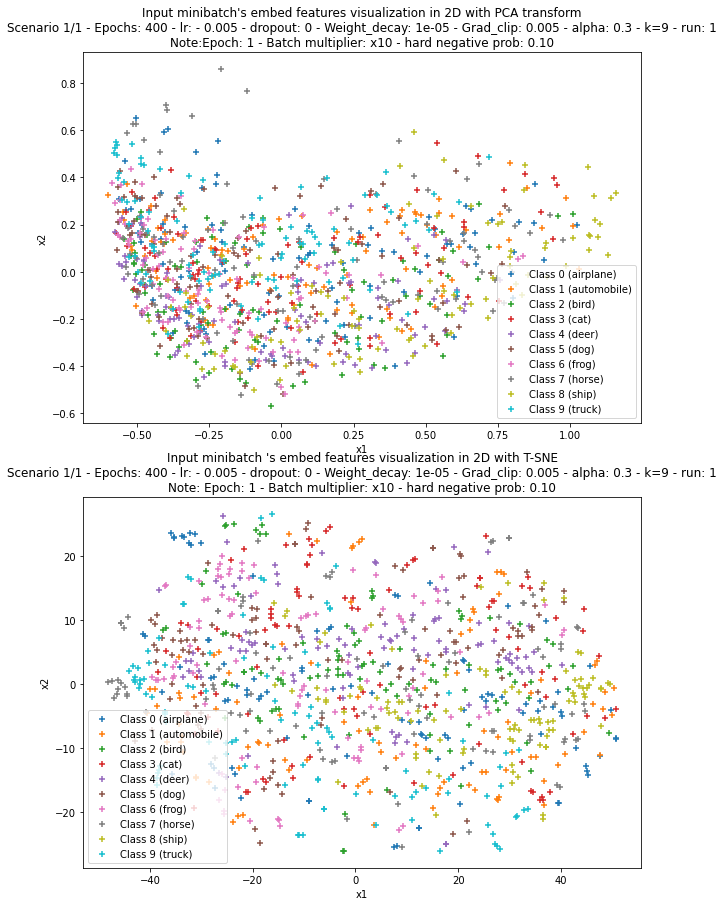

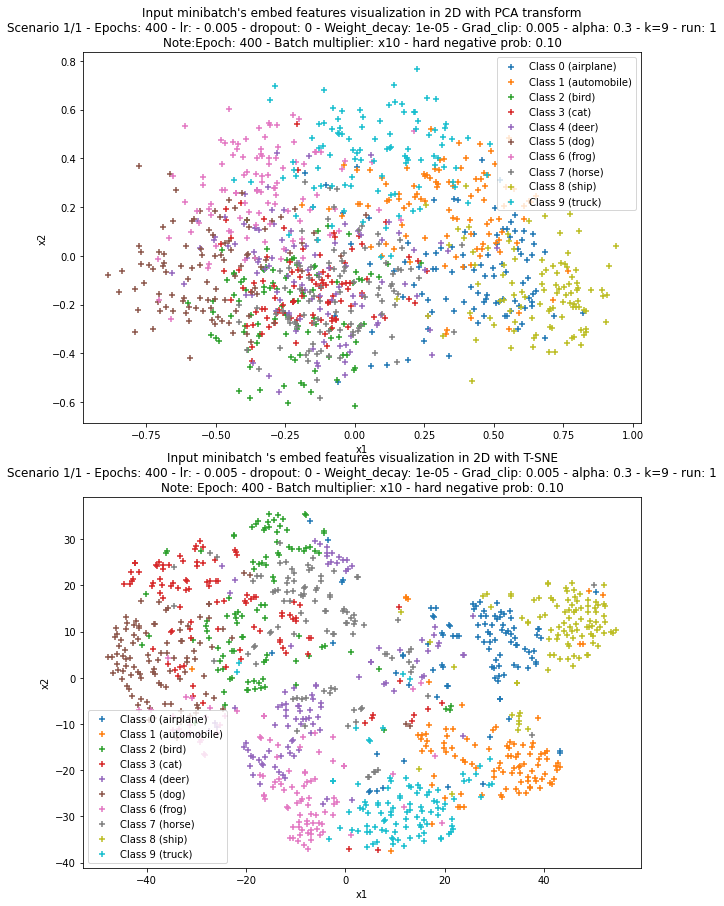

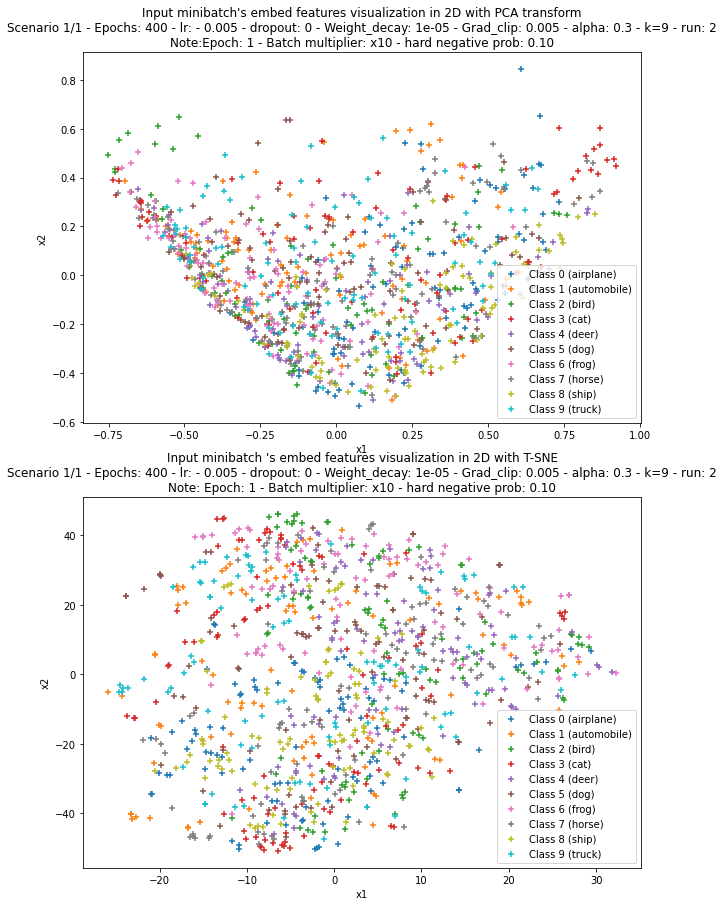

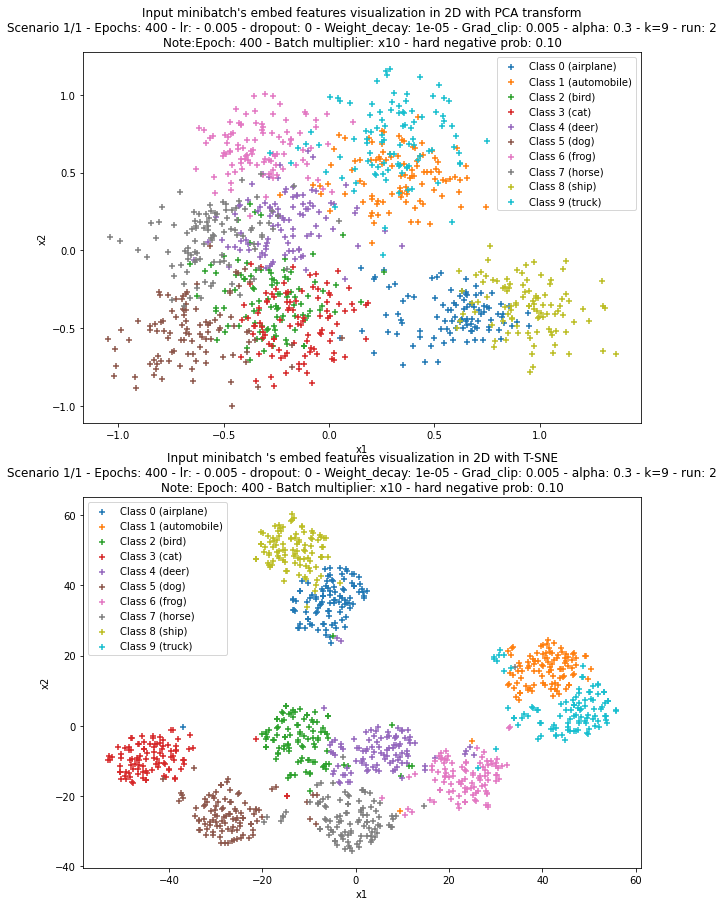

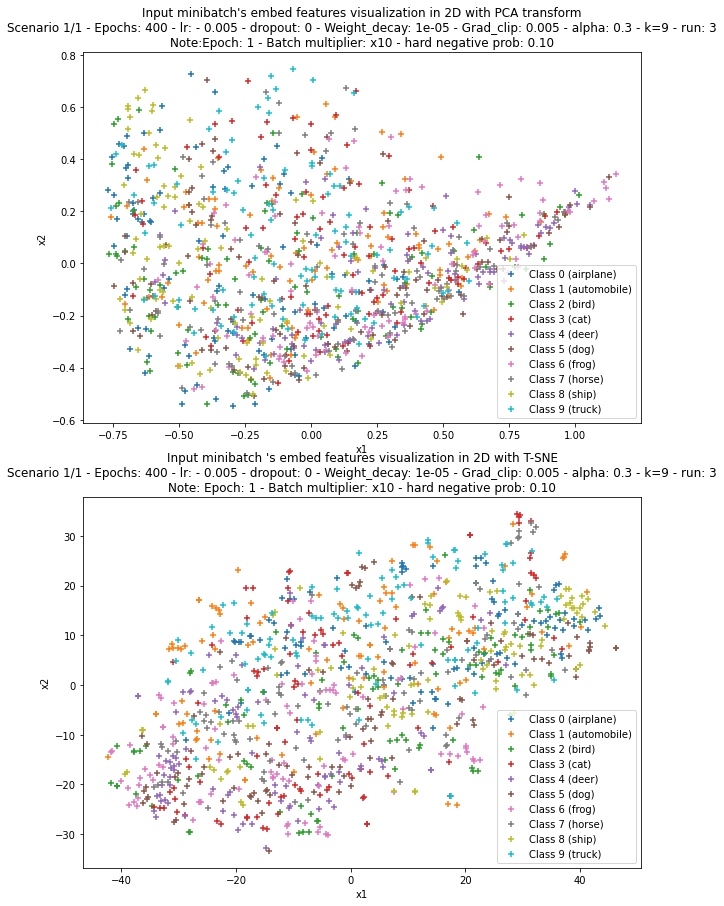

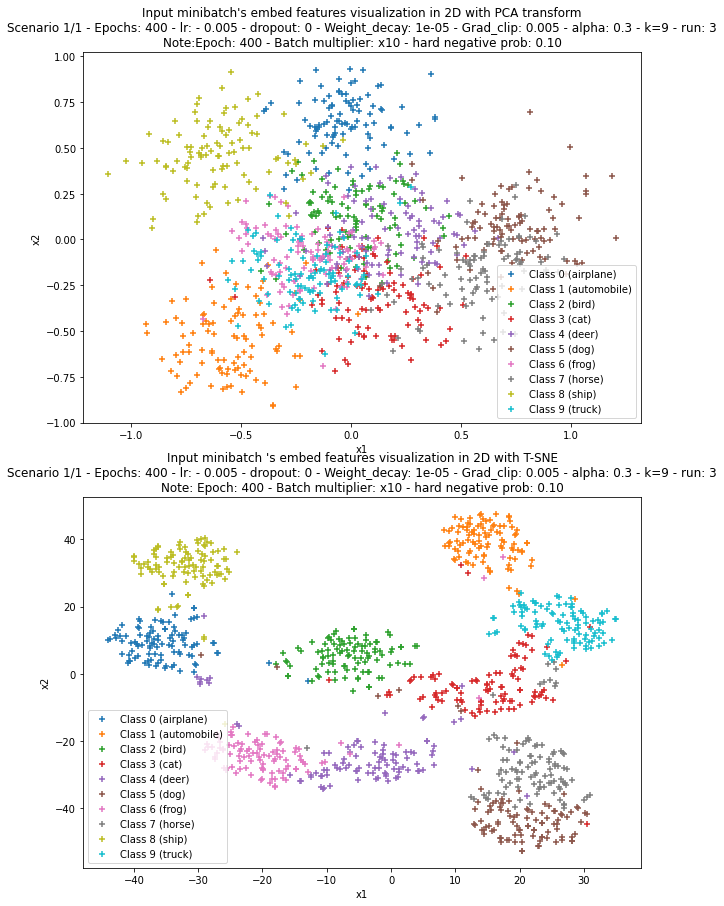

In [14]:
#%%time

device_name = torch.cuda.get_device_name(0) if device == torch.device('cuda') else 'cpu'
scenario_count = len(epochs_list) * len(weight_decays) * len(lrs) * len(drop_outs) * len(grad_clips)
print(f'Total scenarios: {scenario_count}')
for key, value in save_state.items():
    if key != 'accs':
        print(f'{key}: {value}')  

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
                                    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                    transforms.RandomGrayscale(),
                                    transforms.RandomHorizontalFlip(),
                                    torchvision.transforms.RandomAffine(degrees=30),
                                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), 
                                    #transforms.ColorJitter(), 
                                    transforms.ToTensor(), 
                                    normalize]) #careful to keep this one same
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 


print('Running on {}'.format(device_name))

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)


# Extract a subset of 100 (class balanced) samples per class
training_done = False
count = 1
scenario = 1
next_run = 1
previous_runs_accs = []
previous_train_times = []
previous_eval_times = []
previous_exec_times = []

ran_in_middle = False

if log_enabled:
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as file_read:
            progress_content = file_read.readlines()
        # print(progress_content)
        if progress_content[0].replace('\n', '') == output_file_name:
            previous_scenario = progress_content[1].replace('\n', '')
            previous_runs_accs = eval(progress_content[2].replace('\n', ''))
            previous_runs = len(previous_runs_accs)
            print(f'Previous progress on {output_file_name} stopped at scenario {previous_scenario}/{scenario_count}' +\
                 f', run {previous_runs}/{runs}')
            if previous_runs >= runs: # Already complete the previous scenario
                scenario = int(previous_scenario) + 1

            else: # Previous scenario just completed partially, resume in the next run
                ran_in_middle = True
                scenario = int(previous_scenario)
                next_run = previous_runs + 1
                previous_execution_times = eval(progress_content[3].replace('\n', ''))
                prev_accs_accross_runs_plot = eval(progress_content[4].replace('\n', ''))
                for i, previous_execution_time in enumerate(previous_execution_times):
                    previous_train_times.append(previous_execution_time[0]) 
                    previous_eval_times.append(previous_execution_time[1]) 
                    previous_exec_times.append(previous_execution_time[2])  
            if scenario > scenario_count:
                training_done = True
                print('Training was already done!')
            else:
                print(f'Will resume training at scenario: {scenario}, run# {next_run}')


if not training_done:
    for epochs in epochs_list:
        for lr in lrs:
            for drop_out in drop_outs:
                for weight_decay in weight_decays:
                    for grad_clip in grad_clips:
                        for alpha in alphas:
                            for k in ks:
                                if not ran_in_middle: 

                                    accs = []
                                    train_times = []
                                    evaluation_times = []
                                    total_times = []
                                    run_execution_times = []
                                    accs_accross_runs_plot = []
                                else:
                                    if count < scenario:
                                        count += 1
                                        continue #skip until reaching the scenario to run
                                    accs = previous_runs_accs
                                    train_times = previous_train_times
                                    evaluation_times = previous_eval_times
                                    total_times = previous_exec_times
                                    run_execution_times = previous_execution_times
                                    accs_accross_runs_plot = prev_accs_accross_runs_plot
                                #scenario += 1
                                scenario_description = 'Scenario %d/%d - Epochs: %d - lr: - %s - dropout: %s - Weight_decay: %s - Grad_clip: %s - alpha: %s - k=%d'%\
                                    (scenario, scenario_count, epochs, lr, drop_out, weight_decay, grad_clip, alpha, k)
                                print(f'\n{scenario_description}')
                                
                                for seed in range(next_run, runs + 1):
                                    start_time = time.time()

                                    prng = RandomState(seed)
                                    random_permute = prng.permutation(np.arange(0, 5000))
                                    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:10]] for classe in range(0, 10)])
                                    indx_val = np.concatenate([np.where(np.array(cifar_data_val.targets) == classe)[0][random_permute[10:210]] for classe in range(0, 10)])


                                    train_data = Subset(cifar_data, indx_train)
                                    val_data = Subset(cifar_data_val, indx_val)

                                    print('  Run# [%d/%d] - Num Samples For Training %d - Num Samples For Val %d'%(seed, runs, train_data.indices.shape[0],val_data.indices.shape[0]))

                                    train_loader = torch.utils.data.DataLoader(train_data,
                                                                                batch_size=batch_size, 
                                                                                shuffle=True)

                                    val_loader = torch.utils.data.DataLoader(val_data,
                                                                            batch_size=batch_size, 
                                                                            shuffle=False)

                                    model = NET(in_channels, num_classes, drop_out)
                                    model.to(device)
                                    optimizer = torch.optim.Adam(model.parameters(), 
                                                                lr=lr, 
                                                                #momentum=0.9,
                                                                weight_decay=weight_decay)
                                    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, 
                                            steps_per_epoch=int(100*batch_multiplier/batch_size))
                                    test_accs = []
                                    eval_time = 0
                                    for epoch in range(epochs):
                                        print_condition = epoch%epoch_display_range == 0 or epoch== epochs - 1
                                        distance_visualize = plot_distance and (epoch == 0 or epoch == epochs - 1)
                                        predict_svm = linear_classifier == 'SVM' and epoch == epochs - 1
                                        train(model, device, train_loader, optimizer, epoch, alpha=alpha, grad_clip=grad_clip,
                                            sched=sched, display=print_condition, distance_visualize=distance_visualize, 
                                            scenario_description=scenario_description + f' - run: {seed}', svm=predict_svm)
                                        
                                        if search_plot:
                                            eval_start = time.time()
                                            test_acc = test(model, device, val_loader, k, display=print_condition, distance_visualize=distance_visualize, svm=predict_svm)
                                            eval_time = time.time() - eval_start
                                            test_accs.append(test_acc)
                                            
                                    train_time = time.time() - start_time    
                                    train_times.append(train_time)
                                    final_eval_start = time.time()
                                    final_acc = test(model, device, val_loader, k, display=print_condition, distance_visualize=distance_visualize, svm=predict_svm) \
                                        if not search_plot else test_accs[-1]
                                    accs.append(final_acc)
                                    final_eval_time = time.time() - final_eval_start  if not search_plot else eval_time
                                    evaluation_times.append(final_eval_time)
                                    if search_plot:
                                        accs_accross_runs_plot.append(test_accs)
                                    total_time = time.time() - start_time
                                    total_times.append(total_time)
                                    run_execution_times.append((train_time, final_eval_time, total_time))
                                    if log_enabled:
                                        progress_str = f'{output_file_name}\n{scenario}\n{accs}\n{run_execution_times}' +\
                                        f'\n{accs_accross_runs_plot}'

                                        with open(progress_file, 'w') as progress_write:
                                            progress_write.write(progress_str)
                                    
                                    del optimizer, model
                                    gc.collect()
                                    if device == torch.device('cuda'):

                                        torch.cuda.empty_cache()
                                    print('  Run execution time: train: %.3f (s) - eval: %.3f (s)- total: %.3f (s)'%\
                                        (train_time, final_eval_time, total_time))
                                accs = np.array(accs)
                                train_times = np.array(train_times)
                                evaluation_times = np.array(evaluation_times)
                                total_times = np.array(total_times)

                                accuracy_description = '\n  Final acc over %d instances: %.2f +- %.2f\n'%(runs, accs.mean(), accs.std())
                                # print(train_times.mean(), evaluation_times.mean(), total_times.mean())
                                display_str = '  %s'%(scenario_description) +\
                                '\n  Avg execution time: train: %.3f +- %.3f (s) - eval: %.3f +- %.3f (s) - total: %.3f +- %.3f (s) on %s'%\
                                (train_times.mean(), train_times.std(), evaluation_times.mean(), evaluation_times.std(),
                                    total_times.mean(), total_times.std(), device_name) + accuracy_description
                                accumulated_accs.append(accs_accross_runs_plot)
                                #progress_str = f'{output_file_name}\n{scenario}\n{accs}'
                                print(display_str)
                                if search_plot:
                                    plot_str = display_str # scenario_description + accuracy_description
                                    plot_accs(accs_accross_runs_plot, plot_str, comment, save_image)
                                if summarize:
                                    save_state['accs'] = accumulated_accs
                                    with open(save_state_file_path, 'wb') as dataHandle:
                                        pickle.dump(save_state, dataHandle)
                                    summary = performance_summary(accumulated_accs)
                                    print(summary)
                                    display_str += summary
                                
                                if log_enabled:
                                    mode = 'a' if os.path.exists(output_file_path) else 'w'

                                    with open(output_file_path, mode) as output_write:
                                        output_write.write(display_str)
                                ran_in_middle = False
                                next_run = 1
                                scenario += 1